# QSARtuna CLI Tutorial

step1,超参数优化：使用Optuna搜索最佳模型配置（only training set  
step2,模型构建：使用最佳配置构建模型并在测试集上评估（only training set  
step3,生产构建：在合并的训练和测试数据上重新训练最终模型（training + test  

### Create configuration

QSARtuna configuration can be read from a JSON file or created in Python. Here we create it in Python.

In [8]:
import sys
sys.path.append(".")

In [9]:
# Start with the imports.
import sklearn
from optunaz.three_step_opt_build_merge import (
    optimize,
    buildconfig_best,
    build_best,
    build_merged,
)
from optunaz.config import ModelMode, OptimizationDirection
from optunaz.config.optconfig import (
    OptimizationConfig,
    SVR,
    RandomForestRegressor,
    Ridge,
    Lasso,
    PLSRegression,
    KNeighborsRegressor
)
from optunaz.datareader import Dataset
from optunaz.descriptors import ECFP, MACCS_keys, ECFP_counts, PathFP, Avalon, JazzyDescriptors, PhyschemDescriptors

In [73]:
%run /home/zhennan/miniforge3/envs/qsar/lib/python3.10/site-packages/optunaz/utils/preprocessing/splitter.py
import pandas as pd
df = pd.read_csv('data.csv')

train_str, test_str = Stratified(fraction=0.2, seed=42, bins="fd").split(df["smiles (Canonical)"], df["DG(MLE) (kcal/mol)"])
df.loc[train_str].to_csv("train.csv", index=False)  
df.loc[test_str].to_csv("test.csv", index=False)

#scaf_split = ScaffoldSplit()
#scaffolds = scaf_split.groups(df, "smiles (Canonical)")
#groups = df["smiles (Canonical)"].map(scaffolds)
#train_sca, test_sca = scaf_split.split(df["smiles (Canonical)"], df["DG(MLE) (kcal/mol)"], groups=groups)
#print("Train (stratified):", len(train_sca))
#print("Test (stratified):", len(test_sca))

Train (stratified): 0
Test (stratified): 60


#### FOR REGRESSION：

In [110]:
# Prepare hyperparameter optimization configuration.
config = OptimizationConfig(
    data=Dataset(
        input_column="smiles (Canonical)",  # Typical names are "SMILES" and "smiles".
        response_column="DG(MLE) (kcal/mol)",  # Often a specific name (like here), or just "activity".
        training_dataset_file="./train.csv",
        test_dataset_file="./test.csv"  # Hidden during optimization.
    ),
    descriptors=[
        ECFP.new(),
        ECFP_counts.new(),
        #MACCS_keys.new(),
        PathFP.new(),
        Avalon.new(),
        JazzyDescriptors(),
        PhyschemDescriptors.new()
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
        KNeighborsRegressor.new(),
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=5,
        n_trials=1000,  # Total number of trials.
        n_startup_trials=800,  # Number of startup ("random") trials.
        random_seed=42, # Seed for reproducability
        direction=OptimizationDirection.MAXIMIZATION,
    ),
) 

#### FOR CLASSIFICATION：

In [2]:
from optunaz.config.optconfig import ChemPropClassifier, RandomForestClassifier, CalibratedClassifierCVWithVA, SVC, LogisticRegression, KNeighborsClassifier
from optunaz.descriptors import SmilesBasedDescriptor, SmilesFromFile

config = OptimizationConfig(
    data=Dataset(
        input_column="SMILES",  # Typical names are "SMILES" and "smiles".
        response_column="active",  # Often a specific name (like here), or just "activity".
        training_dataset_file="./trainset.csv",
        test_dataset_file="./testset-nodup.csv"  # Hidden during optimization.
    ),
    descriptors=[
#        SmilesFromFile.new(),
        ECFP.new(),
        ECFP_counts.new(),
        MACCS_keys.new(),
        PathFP.new(),
        Avalon.new(),
        JazzyDescriptors.new(), 
        PhyschemDescriptors.new()
    ],
    algorithms=[
#        ChemPropClassifier.new(epochs=20),
        RandomForestClassifier.new(n_estimators={"low": 100, "high": 200}),
        CalibratedClassifierCVWithVA.new(
            estimator=RandomForestClassifier.new(
                n_estimators=RandomForestClassifier.Parameters.RandomForestClassifierParametersNEstimators(
                    low=100, high=200
                )
            ),
            n_folds=5,
            ensemble="True",
            method="sigmoid", 
        ),
        SVC.new(), 
        LogisticRegression.new(), 
        KNeighborsClassifier.new()
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=10, #1为禁用交叉验证，5平衡，10慢/小数据使用
        n_trials=100, # run only one random forest classifier trial
#        n_chemprop_trials=10, # run one enqueued chemprop trial and 1 undirected trial
        split_chemprop=True, # this is set to true by default (shown here for illustration)
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

### Run optimization

In [111]:
# Setup basic logging.
import logging
from importlib import reload
reload(logging)
logging.basicConfig(level=logging.INFO)
logging.getLogger("train").disabled = True # Prevent ChemProp from logging
import numpy as np
np.seterr(divide="ignore")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import tqdm
from functools import partialmethod, partial
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True) # Prevent tqdm in ChemProp from flooding log

# Avoid decpreciated warnings from packages etc
import warnings
warnings.simplefilter("ignore")
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [112]:
# Run Optuna Study.
study = optimize(config, study_name="my_study")
# Optuna will log it's progress to sys.stderr
# (usually rendered in red in Jupyter Notebooks).

[I 2025-11-25 12:57:30,710] A new study created in memory with name: my_study
[I 2025-11-25 12:57:30,868] A new study created in memory with name: study_name_0
[I 2025-11-25 12:57:30,994] Trial 0 finished with value: -3.649008207317494 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 3, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 0 with value: -3.649008207317494.
[I 2025-11-25 12:57:31,892] Trial 1 finished with value: -4.964902993374912 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.223705789444759, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", 

Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 12, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3.0052881865569274]


[I 2025-11-25 12:57:33,481] Trial 40 finished with value: -5.705399975758786 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.05049691095545223, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 3.5474230354307966e-09, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 15 with value: -2.298733073131147.
[I 2025-11-25 12:57:33,528] Trial 41 finished with value: -3.185427777777778 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 6, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best i

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [4.036328686662325, 188.01341618884987, 158.90630188749995, 0.6760

[I 2025-11-25 12:57:34,531] Trial 72 finished with value: -4.062483333333333 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 24, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 51 with value: -2.2896277777777776.
[I 2025-11-25 12:57:34,537] Trial 73 pruned. Duplicate parameter set
[I 2025-11-25 12:57:34,555] Trial 74 finished with value: -3.367946785811199 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.1804613337381742, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 4, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-3.0483374999999997]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDe

[I 2025-11-25 12:57:34,756] Trial 81 finished with value: -2.608115584505181 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.33406789218415045, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 51 with value: -2.2896277777777776.
[I 2025-11-25 12:57:34,776] Trial 82 finished with value: -3.233624581404971 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 51 with value: -2.2896277777777776.
[I 2025-11-25 12:57:34,795] Trial 83 finished with value: -5.858527700831026 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.0739488457

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 2, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-4.68685]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.633045666960112]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c3911

/home/zhennan/miniforge3/envs/qsar/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.584e-02, tolerance: 2.880e-02
  model = cd_fast.enet_coordinate_descent(
/home/zhennan/miniforge3/envs/qsar/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.969e-02, tolerance: 2.593e-02
  model = cd_fast.enet_coordinate_descent(
/home/zhennan/miniforge3/envs/qsar/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 2, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-4.04875]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorg

[I 2025-11-25 12:57:35,736] Trial 124 finished with value: -3.389624570883521 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.8944050810096713, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-3.0389163352782305]


[I 2025-11-25 12:57:36,192] Trial 135 finished with value: -3.900806250000001 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 26, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.767

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA

[I 2025-11-25 12:57:36,436] Trial 145 finished with value: -3.4371030246012686 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.6679586902616004]


[I 2025-11-25 12:57:36,721] Trial 156 finished with value: -3.3985617424912142 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.21094739991326117, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"value

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 4, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-3.0483374999999997]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 7, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-2.371220408163265]


[I 2025-11-25 12:57:36,958] Trial 164 finished with value: -3.3316299999999996 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 5, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-2.9726399999999997]


[I 2025-11-25 12:57:37,589] Trial 185 finished with value: -2.9835466126054313 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:37,614] Trial 186 finished with value: -3.0630709373201577 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:37,681] Trial 187 finished with value: -4.1818159999999995 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba3

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.633045666960112]


[I 2025-11-25 12:57:37,933] Trial 191 finished with value: -5.49908825479948 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.0004634347469211958, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 0.49983023133854937, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:38,000] Trial 192 finished with value: -3.5963243148148143 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 11, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-3.9134338847624948]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 1, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-6.000200000000001]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe

[I 2025-11-25 12:57:38,267] Trial 202 finished with value: -3.8466577755083264 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.6237277158337664, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:38,335] Trial 203 finished with value: -3.273865625 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 25, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPar

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA

[I 2025-11-25 12:57:38,772] Trial 216 finished with value: -3.5294842014239594 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.8815690410062158, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:38,799] Trial 217 finished with value: -5.148085074860708 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.8504563708753878, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:38,868] Trial 218 finished with value: -2.616046264124292 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA

[I 2025-11-25 12:57:39,114] Trial 224 finished with value: -3.835070980456563 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:39,183] Trial 225 finished with value: -2.932402469135803 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 19, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.977739259169863]


[I 2025-11-25 12:57:39,425] Trial 231 finished with value: -3.4109283950617284 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 23, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.233624581404971]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 7, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-2.371220408163265]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex",

[I 2025-11-25 12:57:39,652] Trial 239 pruned. Duplicate parameter set
[I 2025-11-25 12:57:39,669] Trial 240 pruned. Duplicate parameter set
[I 2025-11-25 12:57:39,739] Trial 241 finished with value: -3.4109283950617284 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 24, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI",

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 10, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-2.633524]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.9835466126054313]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae

[I 2025-11-25 12:57:39,972] Trial 245 pruned. Duplicate parameter set
[I 2025-11-25 12:57:39,989] Trial 246 pruned. Duplicate parameter set
[I 2025-11-25 12:57:40,017] Trial 247 finished with value: -3.7229279141552523 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.14821084514973415, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:40,077] Trial 248 finished with value: -2.9936312499999995 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 8, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radi

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [4.036328686662325, 188.01341618884987, 158.90630188749995, 0.6760

[I 2025-11-25 12:57:40,208] Trial 250 finished with value: -2.3196593749999996 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 8, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:40,281] Trial 251 finished with value: -2.899231700932225 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": 

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA

[I 2025-11-25 12:57:40,796] Trial 266 finished with value: -3.1672709360614695 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.6048390225570728, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:40,827] Trial 267 finished with value: -5.70539999994495 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 8.595819099481208, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 4.827749460278399e-10, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAb

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA

[I 2025-11-25 12:57:41,070] Trial 274 finished with value: -4.150717291407304 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.6808231122285193, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:41,101] Trial 275 finished with value: -5.4940103782746705 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.8980775358602517, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:41,132] Trial 276 finished with value: -3.546268163531221 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.54554283933015

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 2, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-4.68685]


[I 2025-11-25 12:57:41,527] Trial 283 finished with value: -2.299817283950617 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 9, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:41,559] Trial 284 finished with value: -5.705399986804719 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 76.45561082631642, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 3.770080726196557e-08, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.27465831348897

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3.319142817190663]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "Bal

[I 2025-11-25 12:57:41,830] Trial 288 finished with value: -3.1775288888888884 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 14, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:41,862] Trial 289 finished with value: -3.1405193791663577 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.101326758881703, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:41,894] Tr

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 9, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3.0050320987654318]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 2, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-4.68685]


[I 2025-11-25 12:57:43,189] Trial 317 finished with value: -3.024250847222222 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 23, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:43,212] Trial 318 pruned. Duplicate parameter set
[I 2025-11-25 12:57:43,232] Trial 319 pruned. Duplicate parameter set
[I 2025-11-25 12:57:43,253] Trial 320 pruned. Duplicate parameter set
[I 2025-11-25 12:57:43,285] Trial 321 finished with value: -2.8200583768561946 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [4.036328686662325, 188.01341618884987, 158.90630188749995, 0.6760

[I 2025-11-25 12:57:43,452] Trial 324 finished with value: -3.0402244897959187 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 7, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 6, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3.185427777777778]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-3.0630709373201577]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOW

[I 2025-11-25 12:57:43,777] Trial 334 finished with value: -3.803 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 1, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:43,812] Trial 335 finished with value: -5.469236268895722 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 49.61792947443608, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 3.591021129723954, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 wit

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [4.036328686662325, 188.01341618884987, 158.90630188749995, 0.6760

[I 2025-11-25 12:57:44,095] Trial 343 finished with value: -3.5963243148148143 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 25, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:44,258] Trial 344 finished with value: -5.858527700831026 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.3434177184881215, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:44,336] Trial 345 finished with value: -

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.977739259169863]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 7, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-2.371220408163265]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"parameters": {"jazzy_names": ["dga"

[I 2025-11-25 12:57:44,697] Trial 355 finished with value: -2.7869040000000003 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 5, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 5, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.68582708333333

[I 2025-11-25 12:57:44,988] Trial 363 finished with value: -5.725569731393518 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 54.18721162660631, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 27.770985644799328, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"nu

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.5415429097067324]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3.4065247489572696]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 8, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radi

[I 2025-11-25 12:57:45,417] Trial 372 finished with value: -2.6601388888888886 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 6, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 1, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-6.5906]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 4, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.0825625000000003]


[I 2025-11-25 12:57:46,242] Trial 388 finished with value: -3.654528395061728 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 15, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:46,281] Trial 389 finished with value: -5.858527700831026 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.8763623450494449, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preproc

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-3.9134338847624948]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-3.0389163352782305]


[I 2025-11-25 12:57:46,683] Trial 396 pruned. Duplicate parameter set
[I 2025-11-25 12:57:46,763] Trial 397 finished with value: -4.167416 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 26, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 5, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.68582708333333

[I 2025-11-25 12:57:46,924] Trial 399 finished with value: -2.985923964444444 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 14, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:46,952] Trial 400 pruned. Duplicate parameter set
[I 2025-11-25 12:57:47,032] Trial 401 finished with value: -2.932402469135803 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 23, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [4.036328686662325, 188.01341618884987, 158.90630188749995, 0.6760

[I 2025-11-25 12:57:47,171] Trial 405 pruned. Duplicate parameter set
[I 2025-11-25 12:57:47,212] Trial 406 finished with value: -5.554774690605596 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.7069463841214412, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-2.8200583768561946]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 3, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-3.0999555555555554]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c3

[I 2025-11-25 12:57:47,379] Trial 411 pruned. Duplicate parameter set
[I 2025-11-25 12:57:47,462] Trial 412 finished with value: -3.0739159365079365 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 16, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:47,501] Trial 413 finished with value: -3.1862839721089227 and parameters: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 3, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.6388666666666665]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 6, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.593672222222222]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor'

[I 2025-11-25 12:57:47,775] Trial 416 finished with value: -4.106360633420909 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 3, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:47,814] Trial 417 finished with value: -3.5512047698433378 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.9953445265293184, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:47,854] Trial 418 finished with value: -3.7992343786708944 and parameters:

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA

[I 2025-11-25 12:57:48,192] Trial 425 finished with value: -3.723496 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 27, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.633045666960112]


[I 2025-11-25 12:57:48,511] Trial 431 finished with value: -4.033656790123457 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 32, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.767

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 10, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-2.99559]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 3, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-3.0999555555555554]


[I 2025-11-25 12:57:48,914] Trial 436 finished with value: -2.8657613516530964 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:48,956] Trial 437 finished with value: -4.355710745190358 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.9924489860892773, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElec

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA

[I 2025-11-25 12:57:49,373] Trial 446 finished with value: -3.1775288888888884 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 27, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:49,404] Trial 447 pruned. Duplicate parameter set
[I 2025-11-25 12:57:49,448] Trial 448 finished with value: -7.5085999999999995 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 1, 'weights__170

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [4.036328686662325, 188.01341618884987, 158.90630188749995, 0.6760

[I 2025-11-25 12:57:49,645] Trial 452 finished with value: -2.4437985191070486 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.20233123922620644, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:49,728] Trial 453 finished with value: -3.723496 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 15, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectr

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 4, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "H

[I 2025-11-25 12:57:50,412] Trial 463 finished with value: -4.110146070640134 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:50,455] Trial 464 finished with value: -5.87518890932479 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 4.971346628641339, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 17.773545437333404, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:50,487] Trial 465 pruned. Duplicate p

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 3, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.6388666666666665]


[I 2025-11-25 12:57:50,695] Trial 469 pruned. Duplicate parameter set
[I 2025-11-25 12:57:50,853] Trial 470 pruned. Duplicate parameter set
[I 2025-11-25 12:57:50,895] Trial 471 finished with value: -5.7054 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 16.08195775049715, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 1.5324800926650134e-05, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.


Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA

[I 2025-11-25 12:57:50,981] Trial 472 finished with value: -3.0739159365079365 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 26, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:51,068] Trial 473 finished with value: -2.81052475 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP",

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-3.1862839721089227]


[I 2025-11-25 12:57:51,310] Trial 478 finished with value: -3.2920828463008562 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.0601046784247616, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [4.036328686662325, 188.01341618884987, 158.90630188749995, 0.6760

[I 2025-11-25 12:57:51,577] Trial 484 finished with value: -3.1203922469135805 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 12, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:51,662] Trial 485 finished with value: -2.9324024691358024 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 32, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": 

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [4.036328686662325, 188.01341618884987, 158.90630188749995, 0.6760

[I 2025-11-25 12:57:52,277] Trial 496 finished with value: -3.3555553579084587 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.4509363369003256, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 3, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-3.0999555555555554]


[I 2025-11-25 12:57:52,750] Trial 503 finished with value: -5.700102241299801 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 1.792255977491073, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 0.7672440743744997, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:52,795] Trial 504 finished with value: -3.1633675111983535 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.6747181567145593, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:52,839] Trial 505 finished with value: -5.622788525951991 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash':

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA

[I 2025-11-25 12:57:53,233] Trial 513 finished with value: -5.705390810739315 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.0014512520919471024, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 9.895076190023692e-06, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\"

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 7, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-2.371220408163265]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 10, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "Exact

[I 2025-11-25 12:57:53,509] Trial 519 finished with value: -2.8759896611605527 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 3, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:53,719] Trial 520 finished with value: -2.932402469135803 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 11, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "E

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3.319142817190663]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-3.1862839721089227]


[I 2025-11-25 12:57:55,028] Trial 539 pruned. Duplicate parameter set
[I 2025-11-25 12:57:55,075] Trial 540 finished with value: -2.4625882486757034 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.7663289371182516, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:55,111] Trial 541 pruned. Duplicate parameter set
[I 2025-11-25 12:57:55,159] Trial 542 finished with value: -5.70489639332906 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.010747913551503315, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 4.7997564746800914e-05, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAto

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 6, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.0884833333333335]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 3, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.6388666666666665]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm

[I 2025-11-25 12:57:55,242] Trial 544 finished with value: -2.7318207574198974 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.3808269920498204, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:55,290] Trial 545 finished with value: -5.206306405767067 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.8603518168886264, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:55,337] Trial 546 finished with value: -2.4587523060748486 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3.319142817190663]


[I 2025-11-25 12:57:55,945] Trial 555 finished with value: -5.705399999049449 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 66.68193084109384, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 1.2840530005718715e-08, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-3.9134338847624948]
Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 2, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_see

[I 2025-11-25 12:57:56,197] Trial 561 pruned. Duplicate parameter set
[I 2025-11-25 12:57:56,245] Trial 562 finished with value: -3.5400992779050164 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.665787189774459, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:56,293] Trial 563 finished with value: -5.858527700831026 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.218935526733244, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.


Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 6, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "H

[I 2025-11-25 12:57:56,467] Trial 564 finished with value: -2.468366613980932 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.0952322013074942, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:56,515] Trial 565 finished with value: -5.7053999982700905 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.001416573478095285, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 5.427500819776757e-10, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:56,563] Trial 566 finished with value: -3.3636131025974834 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 1, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-3.803]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_featu

[I 2025-11-25 12:57:56,802] Trial 572 finished with value: -2.460404698221229 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.6511622650380229, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:56,893] Trial 573 finished with value: -3.7802107604166664 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 23, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:56,943] Trial 574 finished with value: -

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 6, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.0884833333333335]


[I 2025-11-25 12:57:57,221] Trial 577 finished with value: -5.700283971796898 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 95.52117754271775, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 0.10220750202449135, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "Labut

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 1, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-3.803]
Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 14, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-3.8399235637860087]


[I 2025-11-25 12:57:57,929] Trial 589 finished with value: -5.7044507393140105 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.00011355477098554052, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 0.0033658968888458925, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:57,979] Trial 590 finished with value: -3.1300458610684916 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.3075558459123127, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:58,158] Trial 591 finished with value: -5.705399925189511 and parameters: {'algorithm_name': 'SVR', 'SVR_algor

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA

[I 2025-11-25 12:57:58,591] Trial 600 finished with value: -3.348810567562537 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.678816075218544, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.5415429097067324]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 2, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-4.04875]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits

[I 2025-11-25 12:57:58,888] Trial 604 pruned. Duplicate parameter set
[I 2025-11-25 12:57:58,970] Trial 605 finished with value: -3.7475111111111112 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 3, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:59,010] Trial 606 pruned. Duplicate parameter set
[I 2025-11-25 12:57:59,061] Trial 607 finished with value: -5.705398933538287 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 85.03010020135987, 'C__ea7ccc7ef4a9329af0d4e39eb6184

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [4.036328686662325, 188.01341618884987, 158.90630188749995, 0.6760

[I 2025-11-25 12:57:59,247] Trial 611 pruned. Duplicate parameter set
[I 2025-11-25 12:57:59,299] Trial 612 finished with value: -3.7665582989884117 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.3710772411252465, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:59,351] Trial 613 finished with value: -4.2512942897766495 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.013576348047179554, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:59,403] Trial 614 finished with value: -5.705386864380741 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 8, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "H

[I 2025-11-25 12:57:59,482] Trial 616 pruned. Duplicate parameter set
[I 2025-11-25 12:57:59,647] Trial 617 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 2, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-4.68685]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-2.8200583768561946]


[I 2025-11-25 12:57:59,698] Trial 618 finished with value: -5.305227627816187 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.35093892211698957, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 9.088067452840253, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:59,749] Trial 619 finished with value: -4.445103537674102 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.3669157695177301, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:57:59,843] Trial 620 finished with value: -3.4109283950617284 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-3.0630709373201577]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 9, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-2.7689333333333335]


[I 2025-11-25 12:58:00,213] Trial 627 pruned. Duplicate parameter set
[I 2025-11-25 12:58:00,265] Trial 628 finished with value: -3.435908710334561 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.34135487060446734, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 7, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.68582708333333

[I 2025-11-25 12:58:00,487] Trial 630 finished with value: -5.705092640552172 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.0028121427407471343, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 0.00013082117913135928, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:00,587] Trial 631 finished with value: -3.9564429705215423 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "Mo

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 3, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-3.0999555555555554]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 2, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "Exact

[I 2025-11-25 12:58:00,860] Trial 637 finished with value: -4.033949893654055 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.8489856653530703, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:00,955] Trial 638 finished with value: -3.1203922469135805 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 23, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:01,009] Trial 639 finished with va

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 8, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.68582708333333

[I 2025-11-25 12:58:01,669] Trial 647 finished with value: -4.034334224965706 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.767

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [4.036328686662325, 188.01341618884987, 158.90630188749995, 0.6760

[I 2025-11-25 12:58:02,017] Trial 654 finished with value: -4.127496620119848 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.711936781664473, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:02,213] Trial 655 finished with value: -5.70526361880274 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.032550221100107385, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 1.5209828170662905e-05, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:02,258] Trial 656 pruned. Duplicate parameter set
[I 2025-11-25 12:58:02,354] Trial 657 finished with value: -3.9073555555555557 and parame

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 9, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "H

[I 2025-11-25 12:58:02,470] Trial 659 finished with value: -5.70501144552818 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.0006634371813677917, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 0.00012057034083834016, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", 

Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.899231700932225]


[I 2025-11-25 12:58:02,777] Trial 664 finished with value: -3.1491673469387758 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 7, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:02,820] Trial 665 pruned. Duplicate parameter set
[I 2025-11-25 12:58:02,918] Trial 666 finished with value: -3.2718677090795416 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'max_features__f1ac

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.233624581404971]


[I 2025-11-25 12:58:03,104] Trial 667 finished with value: -4.6475185842620546 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.5108745450311623, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3.319142817190663]


[I 2025-11-25 12:58:03,830] Trial 678 pruned. Duplicate parameter set
[I 2025-11-25 12:58:03,884] Trial 679 finished with value: -4.745702915844295 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.7854702284484552, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:03,941] Trial 680 finished with value: -5.671228092994401 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 5.071344055248058, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 0.14435182617066436, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", 

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [4.036328686662325, 188.01341618884987, 158.90630188749995, 0.6760

[I 2025-11-25 12:58:04,096] Trial 682 finished with value: -3.723496 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 24, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 10, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.351028]
Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-3.831730427473387]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_

[I 2025-11-25 12:58:04,546] Trial 688 finished with value: -2.99628125 and parameters: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 8, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:04,645] Trial 689 finished with value: -3.0052881865569274 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 31, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "param

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 10, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "

[I 2025-11-25 12:58:04,931] Trial 694 pruned. Duplicate parameter set
[I 2025-11-25 12:58:04,986] Trial 695 finished with value: -5.041964621052136 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.047432720611581214, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:05,043] Trial 696 finished with value: -3.892460331113182 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.0976835111869476, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:05,100] Trial 697 finished with value: -5.7053999989303374 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 1, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "H

[I 2025-11-25 12:58:05,144] Trial 698 pruned. Duplicate parameter set
[I 2025-11-25 12:58:05,329] Trial 699 finished with value: -5.705339073129656 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 3.932835272542859, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 1.9697596035446474e-05, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-3.9134338847624948]


[I 2025-11-25 12:58:05,385] Trial 700 finished with value: -5.657274524585194 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.996842467847548, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:05,442] Trial 701 finished with value: -5.701410095095321 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 13.368291185210557, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 0.01742663548757981, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:05,540] Trial 702 finished with value: -3.4037565809514 and parameters: {'algorithm_name': 'RandomForestRegressor', 'Ra

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 10, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.6858270833333

[I 2025-11-25 12:58:05,840] Trial 708 finished with value: -5.705399958915912 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.0007555068381647907, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 1.8499405206617897e-08, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:05,885] Trial 709 pruned. Duplicate parameter set
[I 2025-11-25 12:58:06,078] Trial 710 finished with value: -3.3985271217753934 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.21191182268809539, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 10, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.351028]


[I 2025-11-25 12:58:06,124] Trial 711 pruned. Duplicate parameter set
[I 2025-11-25 12:58:06,168] Trial 712 pruned. Duplicate parameter set
[I 2025-11-25 12:58:06,211] Trial 713 pruned. Duplicate parameter set
[I 2025-11-25 12:58:06,267] Trial 714 finished with value: -5.479130556147721 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.8668266408991099, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.


Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA

[I 2025-11-25 12:58:06,366] Trial 715 finished with value: -4.093208000000001 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 12, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:06,424] Trial 716 finished with value: -4.923278145787688 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.394182276521517, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:06,482] Trial 717 finished with value: -7.103984076

Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-2.990988375606576]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3.405495212375361]


[I 2025-11-25 12:58:06,918] Trial 722 pruned. Duplicate parameter set
[I 2025-11-25 12:58:07,015] Trial 723 finished with value: -4.244347109392934 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 6, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:07,073] Trial 724 finished with value: -5.705399999869135 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 2.935094401431716, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 3.717175674983684e-10, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 w

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-3.1862839721089227]


[I 2025-11-25 12:58:07,131] Trial 725 finished with value: -4.013410210331757 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.6578395564214488, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:07,175] Trial 726 pruned. Duplicate parameter set
[I 2025-11-25 12:58:07,233] Trial 727 finished with value: -5.705399999924894 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.0010855621123197362, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 1.0754392108812951e-10, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\",

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-3.0630709373201577]


[I 2025-11-25 12:58:07,408] Trial 730 finished with value: -3.68351425513218 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.5849133382785265, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:07,454] Trial 731 pruned. Duplicate parameter set
[I 2025-11-25 12:58:07,645] Trial 732 finished with value: -3.4898216207191197 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.35125293113600464, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"wi

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-3.9134338847624948]


[I 2025-11-25 12:58:07,692] Trial 733 pruned. Duplicate parameter set
[I 2025-11-25 12:58:07,736] Trial 734 pruned. Duplicate parameter set
[I 2025-11-25 12:58:07,793] Trial 735 finished with value: -5.858527700831026 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.6565471296319767, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:07,852] Trial 736 finished with value: -5.814917689451251 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.9879743602869824, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.


Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA

[I 2025-11-25 12:58:07,910] Trial 737 finished with value: -3.611933017960348 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.48990701673191217, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:07,968] Trial 738 finished with value: -2.4715277364978183 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 1.2919030622240901, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:08,015] Trial 739 pruned. Duplicate parameter set
[I 2025-11-25 12:58:08,060] Trial 740 pruned. Duplicate parameter set
[I 2025-11-25 12:58:08,119] Trial 741 finished with value: -5.319411579816714 and parameters: {'a

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 9, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.68582708333333

[I 2025-11-25 12:58:08,358] Trial 742 finished with value: -2.985923964444444 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 19, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:08,405] Trial 743 pruned. Duplicate parameter set
[I 2025-11-25 12:58:08,463] Trial 744 finished with value: -4.85462342766709 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.646452718492999, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateInd

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.233624581404971]


[I 2025-11-25 12:58:08,622] Trial 746 finished with value: -2.932402469135803 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 24, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:08,670] Trial 747 pruned. Duplicate parameter set
[I 2025-11-25 12:58:08,771] Trial 748 finished with value: -4.1818159999999995 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 30, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 10, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': 

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.977739259169863]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 10, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDe

[I 2025-11-25 12:58:08,920] Trial 750 finished with value: -2.932402469135803 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 29, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:08,967] Trial 751 pruned. Duplicate parameter set
[I 2025-11-25 12:58:09,026] Trial 752 finished with value: -5.700166334935444 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.005611792042572246, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 0.000565637924585457, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3,

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3.4065247489572696]


[I 2025-11-25 12:58:09,200] Trial 753 pruned. Duplicate parameter set
[I 2025-11-25 12:58:09,247] Trial 754 pruned. Duplicate parameter set
[I 2025-11-25 12:58:09,306] Trial 755 finished with value: -4.5248315189123876 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.8843082275731655, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:09,353] Trial 756 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 3, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-3.0630709373201577]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ

[I 2025-11-25 12:58:09,400] Trial 757 pruned. Duplicate parameter set
[I 2025-11-25 12:58:09,460] Trial 758 finished with value: -7.1024758123563485 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.20506907622528803, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2",

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-3.0389163352782305]


[I 2025-11-25 12:58:09,734] Trial 762 finished with value: -5.705399894751502 and parameters: {'algorithm_name': 'SVR', 'SVR_algorithm_hash': 'ea7ccc7ef4a9329af0d4e39eb6184933', 'gamma__ea7ccc7ef4a9329af0d4e39eb6184933': 0.12981868030115312, 'C__ea7ccc7ef4a9329af0d4e39eb6184933': 4.775597615997467e-09, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.685827083333335, 1.306322916666667]}, \\"var_\\": {\\"py/object\\": 

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 2, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-2.8200583768561946]
Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 12, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3.0052881865569274]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c391

[I 2025-11-25 12:58:10,427] Trial 770 finished with value: -3.614632653061226 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 27, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:10,498] Trial 771 finished with value: -4.394939654497837 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.014439894007435505, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:10,555] Trial 772 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 3, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "H

[I 2025-11-25 12:58:10,790] Trial 773 finished with value: -3.67008903568899 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:10,840] Trial 774 pruned. Duplicate parameter set
[I 2025-11-25 12:58:10,889] Trial 775 pruned. Duplicate parameter set
[I 2025-11-25 12:58:10,994] Trial 776 finished with value: -3.493176764616609 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 8, 'max_features__f1a

Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"name": "Avalon", "parameters": {"nBits": 2048}}'}, return [-3.6679586902616004]
Duplicated trial: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 30, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-3.0739159365079365]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7

[I 2025-11-25 12:58:11,042] Trial 777 pruned. Duplicate parameter set
[I 2025-11-25 12:58:11,090] Trial 778 pruned. Duplicate parameter set
[I 2025-11-25 12:58:11,153] Trial 779 finished with value: -3.1850733929388646 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.0052796099510706, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 2, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-4.68685]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 8, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}, return [-2.3196593749999996]
Duplicated trial: {'algorithm_name': 'PLSRegres

[I 2025-11-25 12:58:11,314] Trial 782 finished with value: -3.178321902909196 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.0014698122883967, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_V

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 10, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.6858270833333

[I 2025-11-25 12:58:11,807] Trial 787 pruned. Duplicate parameter set
[I 2025-11-25 12:58:11,857] Trial 788 pruned. Duplicate parameter set
[I 2025-11-25 12:58:11,905] Trial 789 pruned. Duplicate parameter set
[I 2025-11-25 12:58:11,957] Trial 790 pruned. Duplicate parameter set
[I 2025-11-25 12:58:12,006] Trial 791 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 4, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-3.0483374999999997]
Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 4, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDe

[I 2025-11-25 12:58:12,058] Trial 792 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'PLSRegression', 'PLSRegression_algorithm_hash': '9f2f76e479633c0bf18cf2912fed9eda', 'n_components__9f2f76e479633c0bf18cf2912fed9eda': 5, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "Chi3v", "Chi4n", "Chi4v", "HallKierAlpha", "Ipc", "Kappa1", "Kappa2", "Kappa3", "LabuteASA", "PEOE_VSA1", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA

[I 2025-11-25 12:58:12,302] Trial 793 finished with value: -3.995706122448979 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 32, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 7, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.767

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 8, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP_counts", "parameters": {"radius": 3, "useFeatures": true, "nBits": 2048}}'}, return [-2.9936312499999995]


[I 2025-11-25 12:58:12,574] Trial 797 pruned. Duplicate parameter set
[I 2025-11-25 12:58:12,623] Trial 798 pruned. Duplicate parameter set
[I 2025-11-25 12:58:12,687] Trial 799 finished with value: -5.249369686038447 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 1.7640963720153973, 'descriptor': '{"parameters": {"rdkit_names": ["MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex", "qed", "SPS", "MolWt", "HeavyAtomMolWt", "ExactMolWt", "NumValenceElectrons", "NumRadicalElectrons", "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge", "FpDensityMorgan1", "FpDensityMorgan2", "FpDensityMorgan3", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "AvgIpc", "BalabanJ", "BertzCT", "Chi0", "Chi0n", "Chi0v", "Chi1", "Chi1n", "Chi1v", "Chi2n", "Chi2v", "Chi3n", "C

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 5, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"parameters": {"jazzy_names": ["dga", "dgp", "dgtot", "sa", "sdc", "sdx"], "jazzy_filters": {"NumHAcceptors": 25, "NumHDonors": 25, "MolWt": 1200}, "scaler": {"saved_params": "{\\"py/object\\": \\"sklearn.preprocessing._data.StandardScaler\\", \\"py/state\\": {\\"with_mean\\": true, \\"with_std\\": true, \\"copy\\": true, \\"n_features_in_\\": 6, \\"n_samples_seen_\\": {\\"py/object\\": \\"numpy.int64\\", \\"dtype\\": \\"int64\\", \\"value\\": 48}, \\"mean_\\": {\\"py/object\\": \\"numpy.ndarray\\", \\"dtype\\": \\"float64\\", \\"values\\": [-37.71694791666667, -153.76792291666663, -147.2287, 8.55085, 15.68582708333333

[I 2025-11-25 12:58:12,829] Trial 801 finished with value: -2.4498806453130126 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.15433268178701923, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:13,033] Trial 802 finished with value: -2.449744393247461 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.14845901186690988, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:13,102] Trial 803 finished with value: -2.450142114892779 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 9, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.428116049382716]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 9, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.428116049382716]


[I 2025-11-25 12:58:18,977] Trial 871 finished with value: -2.4552678825667327 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.3974544433444145, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:19,051] Trial 872 finished with value: -2.448322431675469 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.08792031607595238, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:19,118] Trial 873 pruned. Duplicate parameter set
[I 2025-11-25 12:58:19,191] Trial 874 finished with value: -2.4472248844795432 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algo

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 8, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.5297375]


[I 2025-11-25 12:58:19,389] Trial 875 pruned. Duplicate parameter set
[I 2025-11-25 12:58:19,462] Trial 876 finished with value: -2.451862384010266 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.24125037161241625, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:19,536] Trial 877 finished with value: -2.4491126137839454 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.1213914286033375, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.


Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 9, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.428116049382716]


[I 2025-11-25 12:58:19,602] Trial 878 pruned. Duplicate parameter set
[I 2025-11-25 12:58:19,676] Trial 879 finished with value: -2.4480285064315566 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.07557698020477904, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:19,742] Trial 880 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 8, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.5297375]
Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 9, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.428116049382716]


[I 2025-11-25 12:58:19,821] Trial 881 finished with value: -2.44622348435798 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.0010153371624271892, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:19,896] Trial 882 finished with value: -2.453638708429622 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.32161004792116854, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:19,960] Trial 883 pruned. Duplicate parameter set


Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 10, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.351028]


[I 2025-11-25 12:58:20,167] Trial 884 finished with value: -2.447450018300521 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.051450421940397055, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:20,233] Trial 885 pruned. Duplicate parameter set
[I 2025-11-25 12:58:20,307] Trial 886 finished with value: -2.450374847503755 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.17574608270410946, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:20,381] Trial 887 finished with value: -2.4491089470116947 and parameters: {'algorithm_name': 'Ridge', 'Ridge_alg

Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 8, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.5297375]


[I 2025-11-25 12:58:20,446] Trial 888 pruned. Duplicate parameter set
[I 2025-11-25 12:58:20,520] Trial 889 finished with value: -2.4462474169261674 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.0019902413206392805, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:20,595] Trial 890 finished with value: -2.4481655079737656 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.08132317798588676, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.


Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 9, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.428116049382716]


[I 2025-11-25 12:58:20,660] Trial 891 pruned. Duplicate parameter set
[I 2025-11-25 12:58:20,735] Trial 892 finished with value: -2.449467481481142 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.13656133174834784, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.


Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 10, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.351028]


[I 2025-11-25 12:58:20,940] Trial 893 pruned. Duplicate parameter set
[I 2025-11-25 12:58:21,013] Trial 894 finished with value: -2.4472213726567227 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.041974932957839876, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:21,089] Trial 895 finished with value: -2.450488547354685 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.18069693339683882, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.


Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 7, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.5917306122448984]


[I 2025-11-25 12:58:21,154] Trial 896 pruned. Duplicate parameter set
[I 2025-11-25 12:58:21,229] Trial 897 finished with value: -2.4519058653208283 and parameters: {'algorithm_name': 'Ridge', 'Ridge_algorithm_hash': 'cfa1990d5153c8812982f034d788d7ee', 'alpha__cfa1990d5153c8812982f034d788d7ee': 0.24318925254668253, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:21,304] Trial 898 finished with value: -2.4054832780087425 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.12658082673739945, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.


Duplicated trial: {'algorithm_name': 'KNeighborsRegressor', 'KNeighborsRegressor_algorithm_hash': '1709d2c39117ae29f6c9debe7241287b', 'metric__1709d2c39117ae29f6c9debe7241287b': <KNeighborsMetric.MINKOWSKI: 'minkowski'>, 'n_neighbors__1709d2c39117ae29f6c9debe7241287b': 9, 'weights__1709d2c39117ae29f6c9debe7241287b': <KNeighborsWeights.UNIFORM: 'uniform'>, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}, return [-2.428116049382716]


[I 2025-11-25 12:58:21,381] Trial 899 finished with value: -2.839110328513191 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.10450461040978559, 'descriptor': '{"name": "PathFP", "parameters": {"maxPath": 3, "fpSize": 2048}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:21,457] Trial 900 finished with value: -2.9100453618200453 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f58': 0.4353743526560072, 'descriptor': '{"name": "ECFP", "parameters": {"radius": 3, "nBits": 2048, "returnRdkit": false}}'}. Best is trial 117 with value: -2.2746583134889753.
[I 2025-11-25 12:58:21,668] Trial 901 finished with value: -2.4039758807684186 and parameters: {'algorithm_name': 'Lasso', 'Lasso_algorithm_hash': '5457f609662e44f04dcc9423066d2f58', 'alpha__5457f609662e44f04dcc9423066d2f5

### Visualize optimization progress

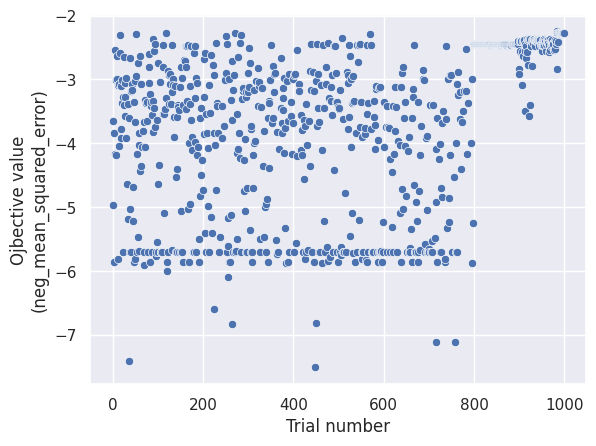

In [113]:
import seaborn as sns
sns.set_theme(style="darkgrid")
default_reg_scoring= config.settings.scoring
ax = sns.scatterplot(data=study.trials_dataframe(), x="number", y="value");
ax.set(xlabel="Trial number", ylabel=f"Ojbective value\n({default_reg_scoring})");

Sometimes it might be interesting to look at individual CV scores instead of aggregated score (mean CV score by default). Here we can plot all 3 cross validation scores (neg_mean_squared_error) for each trial (folds highlighted using different colors).

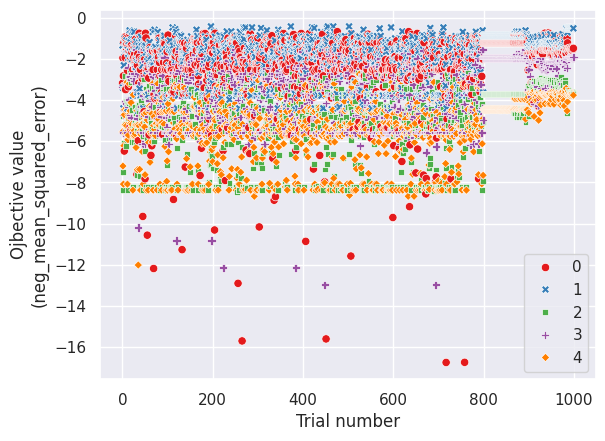

In [114]:
cv_test = study.trials_dataframe()["user_attrs_test_scores"].map(lambda d: d[default_reg_scoring])
x = []
y = []
fold = []
for i, vs in cv_test.items():
    for idx, v in enumerate(vs):
        x.append(i)
        y.append(v)
        fold.append(idx)
ax = sns.scatterplot(x=x, y=y, hue=fold, style=fold, palette='Set1')
ax.set(xlabel="Trial number", ylabel=f"Ojbective value\n({default_reg_scoring})");

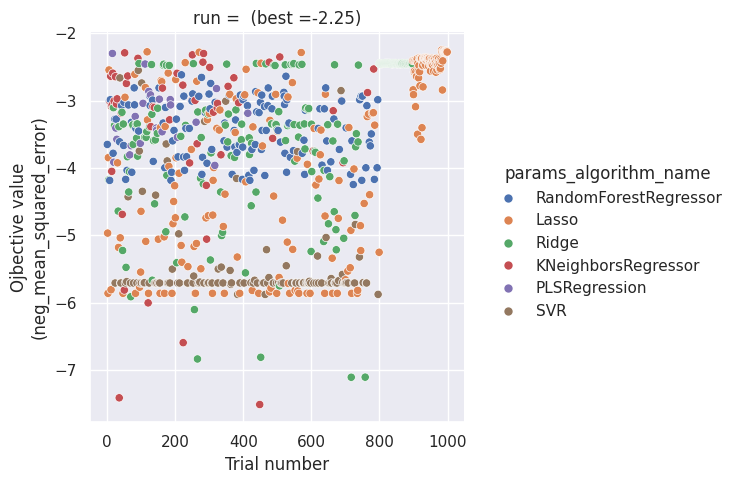

In [115]:
import seaborn as sns

comparison = study.trials_dataframe().assign(run=f' (best ={study.best_value:.2f})')

default_reg_scoring= config.settings.scoring
ax = sns.relplot(data=comparison, x="number", y="value", 
                 col='run',hue='params_algorithm_name', 
                 facet_kws={"sharey":False})
ax.set(xlabel="Trial number",ylabel=f"Ojbective value\n({default_reg_scoring})")
ax.tight_layout()

### Pick the best trial and build a model for it

We pick the best trial, inspect its configuration, build the best model, and save it as a pickled file.

In [116]:
# Get the best Trial from the Study and make a Build (Training) configuration for it.
buildconfig = buildconfig_best(study)

Optional: write out JSON of the best configuration.

In [117]:
import apischema
buildconfig_as_dict = apischema.serialize(buildconfig)

import json
print(json.dumps(buildconfig_as_dict, indent=2))

{
  "data": {
    "training_dataset_file": "./train.csv",
    "input_column": "smiles (Canonical)",
    "response_column": "DG(MLE) (kcal/mol)",
    "response_type": "regression",
    "deduplication_strategy": {
      "name": "KeepMedian"
    },
    "split_strategy": {
      "name": "NoSplitting"
    },
    "test_dataset_file": "./test.csv",
    "save_intermediate_files": false,
    "log_transform": false,
    "log_transform_base": null,
    "log_transform_negative": null,
    "log_transform_unit_conversion": null,
    "probabilistic_threshold_representation": false,
    "probabilistic_threshold_representation_threshold": null,
    "probabilistic_threshold_representation_std": null
  },
  "metadata": {
    "name": "",
    "cross_validation": 5,
    "shuffle": false,
    "best_trial": 983,
    "best_value": -2.248663714967735,
    "n_trials": 1000,
    "visualization": null
  },
  "descriptor": {
    "parameters": {
      "descriptor": {
        "name": "UnscaledPhyschemDescriptors",
  

Build (re-Train) and save the best model. This time training uses all training data, without splitting it into cross-validation folds.

In [118]:
best_build = build_best(buildconfig, "./best_trad.pkl")

Now we can explore how good the best model performs on the test (holdout) set.

In [133]:
import pickle
with open("./best_trad.pkl", "rb") as f:
    model_best = pickle.load(f)
model_best.predict_from_smiles(["NC1=NC=CC=C1C2=NC3=CC=C(C4=C(F)C(N5CC6(CN(C(C)=O)C6)C5)=CC=C4)N=C3N2C7=CC=C(C8(CCC8)N)C=C7", "CC(=O)Nc1ccc(O)cc1"])

array([-0.64625267,  5.69131094])

In [134]:
import pandas as pd

df_best = pd.read_csv(config.data.test_dataset_file)  # Load test data. (OR training_dataset_file, if you want to look)

expected_best = df_best[config.data.response_column]
predicted_best = model_best.predict_from_smiles(df_best[config.data.input_column])
#model_best.predict_from_smiles(df_best[config.data.input_column], explain=True) #explain

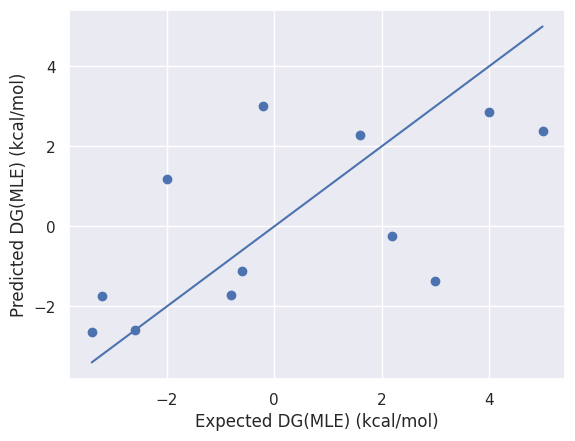

In [135]:
# Plot expected vs predicted values for the best model.
import matplotlib.pyplot as plt
plt.clf()
ax = plt.scatter(expected_best, predicted_best)
lims = [expected_best.min(), expected_best.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {config.data.response_column}");
plt.ylabel(f"Predicted {config.data.response_column}");

We can also calculate custom metrics for the best model:

In [136]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
import numpy as np

# R2
r2 = r2_score(y_true=expected_best, y_pred=predicted_best)

# RMSE. sklearn 0.24 added squared=False to get RMSE, here we use np.sqrt().
rmse = np.sqrt(mean_squared_error(y_true=expected_best, y_pred=predicted_best))  

# MAE
mae = mean_absolute_error(y_true=expected_best, y_pred=predicted_best)

print(f"R2: {r2}, RMSE: {rmse}, Mean absolute error: {mae}")

R2: 0.3583684772573188, RMSE: 2.196725687007957, Mean absolute error: 1.7754582823332117


If the metrics look acceptable, the model is ready for use.

In [ ]:
# FOR CLASSIFICATION
from sklearn.metrics import (roc_auc_score)
import numpy as np

roc_auc = roc_auc_score(y_true=expected_best, y_score=predicted_best)   
print(f"RMSE: {roc_auc}")

### Build merged model

Now we can merge train and test data, and build (train) the model again. We will have no more holdout data to evaluate the model, but hopefully the model will be a little better by seeing a little more data.

In [123]:
# Build (Train) and save the model on the merged train+test data.
build_merged(buildconfig, "./merged_trad.pkl")

In [129]:
import pickle
with open("./merged_trad.pkl", "rb") as f:
    model_merged = pickle.load(f)
model_merged.predict_from_smiles(["NC1=NC=CC=C1C2=NC3=CC=C(C4=C(F)C(N5CC6(CN(C(C)=O)C6)C5)=CC=C4)N=C3N2C7=CC=C(C8(CCC8)N)C=C7", "CC(=O)Nc1ccc(O)cc1"])

array([-3.56924605,  3.93060244])

In [130]:
import pandas as pd

df_merged = pd.read_csv(config.data.test_dataset_file)  # Load test data. (OR training_dataset_file, if you want to look)

expected_merged = df_merged[config.data.response_column]
predicted_merged = model_merged.predict_from_smiles(df_merged[config.data.input_column])
model_merged.predict_from_smiles(df_merged[config.data.input_column], explain=False) #explain

array([-0.29376456,  2.77816208,  0.29974648,  2.69313421,  0.47392414,
       -2.64951554,  0.67642168, -2.64038845, -1.51684808, -0.97330804,
        3.38774366, -2.27761515])

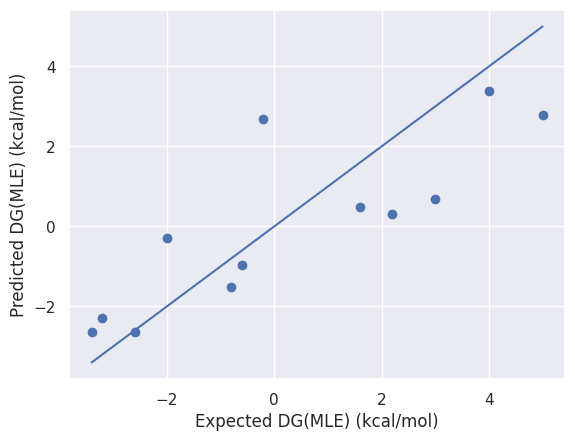

In [131]:
# Plot expected vs predicted values for the merged model.
import matplotlib.pyplot as plt
plt.clf()
ax = plt.scatter(expected_merged, predicted_merged)
lims = [expected_merged.min(), expected_merged.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {config.data.response_column}");
plt.ylabel(f"Predicted {config.data.response_column}");

In [132]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
import numpy as np

# R2
r2 = r2_score(y_true=expected_merged, y_pred=predicted_merged)

# RMSE. sklearn 0.24 added squared=False to get RMSE, here we use np.sqrt().
rmse = np.sqrt(mean_squared_error(y_true=expected_merged, y_pred=predicted_merged))  

# MAE
mae = mean_absolute_error(y_true=expected_merged, y_pred=predicted_merged)

print(f"R2: {r2}, RMSE: {rmse}, Mean absolute error: {mae}")

R2: 0.6791756416482213, RMSE: 1.5533404418984704, Mean absolute error: 1.3004199722136844


In [ ]:
# FOR CLASSIFICATION
from sklearn.metrics import (roc_auc_score)
import numpy as np

roc_auc = roc_auc_score(y_true=expected_merged, y_score=predicted_merged)   
print(f"RMSE: {roc_auc}")

### USE MODLE

In [144]:
import pathlib  
from optunaz.config import ModelMode  
from optunaz.convert import convert  
  
# 转换模型并添加不确定性支持  
convert(  
    pkl_estimator=pathlib.Path("merged_trad.pkl"),  
    mode=ModelMode.REGRESSION,  
    out_name=pathlib.Path("merged_trad_with_uncertainty.pkl"),  
    json_descriptor=None,  # 使用默认的 PrecomputedDescriptorFromFile  
    wrap_for_uncertainty=True  
)

In [145]:
import pickle
with open("./merged_trad_with_uncertainty.pkl", "rb") as f:
    model = pickle.load(f)
model.predict_from_smiles(["CCC", "CC(=O)Nc1ccc(O)cc1"])

array([4.45792531, 3.93060244])

In [146]:
df = pd.read_csv('product.csv')  # Load data.

predicted, unc_predictions = model.predict_from_smiles(df['smiles (Canonical)'], uncert=True)
print(predicted)
print(unc_predictions)

[-2.33367447e+00 -2.14919603e-01 -1.97560935e+00 -5.63438077e-01
  4.18550001e-01 -1.05963659e-01 -1.64808341e+00 -1.50658571e+00
 -1.36182127e+00 -2.21982424e+00 -2.76679400e+00 -6.82836332e-01
 -1.00838076e+00 -1.41726089e+00 -1.89509283e+00 -1.84482767e+00
 -1.57306096e+00 -1.75690452e+00 -1.27349631e+00 -9.12158185e-01
 -1.33962659e+00 -1.61254728e+00 -1.72543522e+00 -8.99372792e-01
 -3.15798672e+00 -2.39446690e+00  1.81100960e-01  1.34231952e+00
 -2.22538247e+00  5.31563874e-01 -1.34030850e+00 -2.69267754e+00
 -2.40274261e+00 -1.58554916e+00  1.39626840e+00 -3.00184736e+00
 -2.11233339e+00  1.11865203e+00 -1.95419947e+00  7.92789594e-01
 -5.55321461e-01 -2.21921507e+00 -2.93168932e-01 -6.62825331e-01
  2.08711167e+00 -1.04753471e+00  1.41915035e+00 -4.02421461e-01
 -2.31821078e+00  1.22786106e+00  1.83083005e+00 -3.96856941e+00
 -1.22246073e+00  2.35740096e+00  3.29654952e-01  2.28290268e+00
  2.79955704e+00 -2.01149623e+00  9.09986051e-01  1.88619278e+00
  7.56380377e-01  2.27262

In [147]:
df['qsar-dGfep-AKTe17k'] = predicted
df['qsar-uncfep-AKTe17k'] = unc_predictions

In [148]:
df.to_csv('product.csv', index=False)